# WHO Global Urban Air Quality

This notebook utilises the [WHO Global Urban Ambient Air Pollution Database (update 2018)](http://www.who.int/airpollution/data/cities/en/) v11 as published on 29-May-2018. 

This database includes measurements of annual mean air pollution levels for more than 4500 settlements in 108 countries.

The following table summarises the [WHO Air Quality Guidelines](http://www.who.int/phe/health_topics/outdoorair/outdoorair_aqg/en/) and interim targets for annual mean particulate matter concentrations. The use of the $PM_{2.5}$ guideline value is preferred as these provide a better indicator of health impact.

Target|$PM_{10}$(ug/m3)|$PM_{2.5}$(ug/m3)|Basis for the selected level
:-----|:--------------:|:---------------:|:---------------------------
Interim target 1 (IT-1)|70|35|Associated with about a 15% higher long-term mortality risk relative to the AQG level
Interim target 2 (IT-2)|50|25|Lowers the risk of premature mortality by approx. 6% relative to the IT-1 level
Interim target 3 (IT-3)|30|15|Lowers the risk of premature mortality by approx. 6% relative to the IT-2 level
Air quality guideline (AQG)|20|10|Level above which total, cardiopulmonary and lung cancer mortality have been shown to increase in response to long term exposure

My motivating question is to use this data to get an overall picture of urban air quality globally and how much progress is being made to improve air quality. 

In particular, I would like to understand how representative this data is of local measurements of air quality in London. 

In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
%matplotlib inline

## Import Data

The WHO Global Urban Ambient Air Pollution Database is published in excel format. This was downloaded locally in order to perform some minor formatting of the column headers. 

The source file contains separate worksheets with the full database and most recent $PM_{2.5}$ and $PM_{10}$ measurements.

The following columns are available though not all will be of interest:

* Region - WHO has 6 regions but the data is futher subdivided by income levels (high income countries HIC, low-medium income countries LMIC) 
* iso3 -  ISO Country Code
* Country - Country Name
* City/Town - City/Town Name
* Year - Year of measurement. Measurements are all in the period 2008 to 2016, however, each Town/City has varying numbers of measurements. 
* PM10 Annual mean, ug/m3 - Annual mean concentration of particulate matter of less than 10 microns of diameter
* PM10 Temporal coverage - The percentage of coverage of the year, as a mean of the percentage coverage of the station, when available
* PM10 note on converted - Indicates if PM10 measurement was measured or converted from PM25 measurement. Converted values are indicative as conversion factors vary by location.  
* PM25 Annual mean, ug/m3 - Annual mean concentration of particulate matter of less than 2.5 microns of diameter
* PM25 Temporal coverage - The percentage of coverage of the year, as a mean of the percentage coverage of the station, when available
* PM25 note on converted - Indicates if PM25 measurement was measured or converted from PM10 measurement. Converted values are indicative as conversion factors vary by location. 
* Number and type of monitoring stations - Notes on numbers and types of monitoring stations used to take measurements
* Reference for air quality - Agency / Source of measurement
* Database version (year) - Year data was reported

The worksheet containing the full database is imported using `pandas`.

In [3]:
who_air_all_raw = pd.read_excel('aap_air_quality_database_2018_v11.xlsx', sheet_name='database')
who_air_all_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12014 entries, 0 to 12013
Data columns (total 15 columns):
Region                                    12014 non-null object
iso3                                      12014 non-null object
Country                                   12014 non-null object
City/Town                                 12014 non-null object
Year                                      12014 non-null int64
PM10 Annual mean, ug/m3                   12014 non-null object
PM10 Temporal coverage                    7642 non-null object
PM10 note on converted                    12014 non-null object
PM25 Annual mean, ug/m3                   12014 non-null object
PM25 Temporal coverage                    4509 non-null object
PM25 note on converted                    12014 non-null object
Number and type of monitoring stations    11951 non-null object
Reference for air quality                 11982 non-null object
Database version (year)                   12014 non-null int64

The separate worksheet containing just the latest available $PM_{2.5}$ measurements by city is also imported. This subset of the data is the most meaningful in terms of current health impact.

In [4]:
who_pm25_latest_raw = pd.read_excel('aap_air_quality_database_2018_v11.xlsx', sheet_name='latest availble PM25 (measured)')
who_pm25_latest_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 15 columns):
Region                                    2625 non-null object
iso3                                      2625 non-null object
Country                                   2625 non-null object
City/Town                                 2625 non-null object
Year                                      2625 non-null int64
PM10 Annual mean, ug/m3                   2625 non-null object
PM10 Temporal coverage                    1046 non-null object
PM10 note on converted                    2625 non-null object
PM25 Annual mean, ug/m3                   2625 non-null int64
PM25 Temporal coverage                    1688 non-null object
PM25 note on converted                    2625 non-null object
Number and type of monitoring stations    2570 non-null object
Reference for air quality                 2605 non-null object
Database version (year)                   2625 non-null int64
Unnamed: 14   

## Wrangle Data

We would like data to be in [Tidy Format](http://vita.had.co.nz/papers/tidy-data.pdf). Fortunately, the data already appears to be well structured with each row representing the air quality measurements for a single location and year. However, we can drop the columns that we do not require. Some columns names are also changed for simplicity.

For the full database we retain the information on the location of the settlement, the year the observation was made and the $PM_{2.5}$ / $PM_{10}$ measurements


In [33]:
who_air_all = who_air_all_raw[['Region','iso3','Country','City/Town','Year','PM10 Annual mean, ug/m3','PM10 note on converted','PM25 Annual mean, ug/m3','PM25 note on converted']]
who_air_all = who_air_all.rename(columns={'PM10 Annual mean, ug/m3':'PM10', 'PM25 Annual mean, ug/m3': 'PM25','PM10 note on converted':'PM10_converted', 'PM25 note on converted': 'PM25_converted'})
who_air_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12014 entries, 0 to 12013
Data columns (total 9 columns):
Region            12014 non-null object
iso3              12014 non-null object
Country           12014 non-null object
City/Town         12014 non-null object
Year              12014 non-null int64
PM10              12014 non-null object
PM10_converted    12014 non-null object
PM25              12014 non-null object
PM25_converted    12014 non-null object
dtypes: int64(1), object(8)
memory usage: 844.8+ KB


Unfotunately, the $PM_{2.5}$ / $PM_{10}$ measurements require cleaning as converted values are stored in brackets with text to indicate these are converted values e.g. `(12)-converted value`

In [34]:
def get_value(value_string):
    return int(re.findall('(\d+)', str(value_string))[0])

who_air_all['PM10'] = who_air_all['PM10'].apply(get_value)
who_air_all['PM25'] = who_air_all['PM25'].apply(get_value)

who_air_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12014 entries, 0 to 12013
Data columns (total 9 columns):
Region            12014 non-null object
iso3              12014 non-null object
Country           12014 non-null object
City/Town         12014 non-null object
Year              12014 non-null int64
PM10              12014 non-null int64
PM10_converted    12014 non-null object
PM25              12014 non-null int64
PM25_converted    12014 non-null object
dtypes: int64(3), object(6)
memory usage: 844.8+ KB


From the $PM_{2.5}$ data we retain just the information on the location of the settlement, the year the observation was made and the $PM_{2.5}$ measurement. Since this data contains no converted $PM_{2.5}$ values we do not have the above problem of cleaning the data values.

In [36]:
who_air_pm25_latest = who_pm25_latest_raw[['Region','iso3','Country','City/Town','Year','PM25 Annual mean, ug/m3']]
who_air_pm25_latest = who_air_pm25_latest.rename(columns={'PM25 Annual mean, ug/m3': 'PM25'})
who_air_pm25_latest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 6 columns):
Region       2625 non-null object
iso3         2625 non-null object
Country      2625 non-null object
City/Town    2625 non-null object
Year         2625 non-null int64
PM25         2625 non-null int64
dtypes: int64(2), object(4)
memory usage: 123.1+ KB


### Data types

For the full dataset, the columns `Region`, `iso3` and `Country` would be managed more efficiently as type `category`. `PM10_converted` and `PM25_converted` and both currently text objects indicating 'Measured' or 'Converted'. This is replaced by a boolean flag indicating if the corresponding value was converted. Categorical variables are added to indicate which level of the WHO Air Quality Guidelines and interim targets are met.

In [37]:
who_air_all.PM10_converted = who_air_all.PM10_converted == 'Converted'
who_air_all.PM25_converted = who_air_all.PM25_converted == 'Converted'
who_air_all.Region = who_air_all.Region.astype('category')
who_air_all.iso3 = who_air_all.iso3.astype('category')
who_air_all.Country = who_air_all.Country.astype('category')
PM10_AQG_array = np.array([0,20,30,50,70,1000])
who_air_all['PM10_AQG_level'] = pd.cut(who_air_all.PM10, PM10_AQG_array,labels=["AQG","IT-3","IT-2","IT-1","Below Target"])
PM25_AQG_array = np.array([0,10,15,25,35,1000])
who_air_all['PM25_AQG_level'] = pd.cut(who_air_all.PM25, PM25_AQG_array,labels=["AQG","IT-3","IT-2","IT-1","Below Target"])
who_air_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12014 entries, 0 to 12013
Data columns (total 11 columns):
Region            12014 non-null category
iso3              12014 non-null category
Country           12014 non-null category
City/Town         12014 non-null object
Year              12014 non-null int64
PM10              12014 non-null int64
PM10_converted    12014 non-null bool
PM25              12014 non-null int64
PM25_converted    12014 non-null bool
PM10_AQG_level    12014 non-null category
PM25_AQG_level    12014 non-null category
dtypes: bool(2), category(5), int64(3), object(1)
memory usage: 470.1+ KB


For the $PM_{2.5}$ data, the columns Region, iso3 and Country would also be managed more efficiently as type `category`. In this case, the PM25 column only contains measured values. Categorical variables are also added to indicate which level of the WHO Air Quality Guidelines and interim targets are met.

In [38]:
who_air_pm25_latest.Region = who_air_pm25_latest.Region.astype('category')
who_air_pm25_latest.iso3 = who_air_pm25_latest.iso3.astype('category')
who_air_pm25_latest.Country = who_air_pm25_latest.Country.astype('category')
who_air_pm25_latest['PM25_AQG_level'] = pd.cut(who_air_pm25_latest.PM25, PM25_AQG_array,labels=["AQG","IT-3","IT-2","IT-1","Below Target"])
who_air_pm25_latest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 7 columns):
Region            2625 non-null category
iso3              2625 non-null category
Country           2625 non-null category
City/Town         2625 non-null object
Year              2625 non-null int64
PM25              2625 non-null int64
PM25_AQG_level    2625 non-null category
dtypes: category(4), int64(2), object(1)
memory usage: 78.8+ KB


## Exploratory Analysis

It seems we are in the fortunate position of having a complete dataset (i.e. no missing values) so we can advance to some initial analysis of the distribution of the data.

### Full dataset

In [39]:
who_air_all.describe()

,Year,PM10,PM25
count,12014.000000,12014.000000,12014.000000
mean,2014.320459,30.894873,18.106792
std,1.393586,30.346017,15.667214
min,2008.000000,1.000000,1.000000
25%,2013.000000,17.000000,10.000000
50%,2014.000000,21.000000,14.000000
75%,2015.000000,31.000000,20.000000
max,2017.000000,540.000000,217.000000


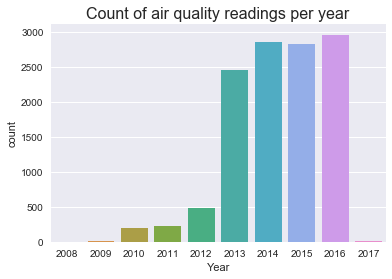

In [40]:
ax = sns.countplot(x='Year', data=who_air_all);
ax.set_title('Count of air quality readings per year',fontsize=16);

We can see that the full dataset includes the majority of observations for years between 2013 to 2016. 

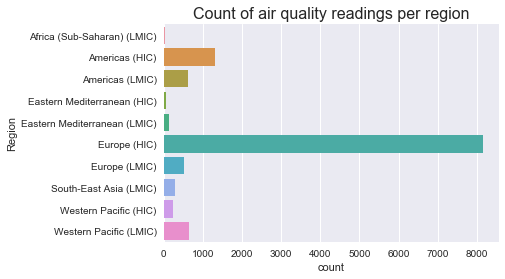

In [41]:
ax = sns.countplot(y='Region', data=who_air_all);
ax.set_title('Count of air quality readings per region',fontsize=16);

Most observations relate to European high income countries (HIC).

In [42]:
settlements_per_region = who_air_all.groupby(by=['Region'])['City/Town'].nunique()
countries_per_region = who_air_all.groupby(by=['Region'])['Country'].nunique()
per_region = pd.concat((settlements_per_region, countries_per_region),axis=1, join='inner')
print(per_region)

                              City/Town  Country
Region                                          
Africa (Sub-Saharan) (LMIC)          28        9
Americas (HIC)                      758        4
Americas (LMIC)                     169       16
Eastern Mediterranean (HIC)          34        6
Eastern Mediterranean (LMIC)        101        9
Europe (HIC)                       2479       32
Europe (LMIC)                       262       12
South-East Asia (LMIC)              198        9
Western Pacific (HIC)               125        5
Western Pacific (LMIC)              355        6


The regional distribution of observations in the full dataset is further detailed in the above table.

The full dataset contains observations from 4509 settlements in  108 countries.


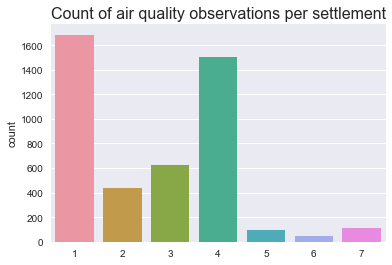

In [43]:
print("The full dataset contains observations from", who_air_all.groupby(['Region', 'City/Town']).ngroups, "settlements in ", who_air_all['Country'].nunique(), "countries.")
settlement_readings = who_air_all.groupby(['Region', 'City/Town']).size()
ax = sns.countplot(x=settlement_readings);
ax.set_title('Count of air quality observations per settlement',fontsize=16);

A significant number of the settlements (as indicated by grouping on `Region` and `City/Town`) have only one observation in the dataset. However, around half the settlements have observations for 3 or more years.

In [44]:
settlement_readings.sort_values(ascending=False).head(10)

Region                 City/Town            
Europe (HIC)           Morges                   7
Western Pacific (HIC)  Albany                   7
Americas (LMIC)        Catanduva                7
                       Sao Jose Do Rio Preto    7
                       Sao Paulo                7
                       Sorocaba                 7
Europe (HIC)           Chur                     7
Americas (LMIC)        Taboao Da Serra          7
Europe (HIC)           Chiasso                  7
Americas (HIC)         Talagante                7
dtype: int64

Examples of settlements with the most number of observations include Sao Paulo in Brazil which has measured $PM_{2.5}$ and $PM_{10}$ values for a period of seven years.

In [45]:
who_air_all[who_air_all['City/Town'] == 'Sao Paulo']

,Region,iso3,Country,City/Town,Year,PM10,PM10_converted,PM25,PM25_converted,PM10_AQG_level,PM25_AQG_level
1338,Americas (LMIC),BRA,Brazil,Sao Paulo,2010,37,False,17,False,IT-2,IT-2
1339,Americas (LMIC),BRA,Brazil,Sao Paulo,2011,36,False,20,False,IT-2,IT-2
1340,Americas (LMIC),BRA,Brazil,Sao Paulo,2012,35,False,18,False,IT-2,IT-2
1341,Americas (LMIC),BRA,Brazil,Sao Paulo,2013,33,False,16,False,IT-2,IT-2
1342,Americas (LMIC),BRA,Brazil,Sao Paulo,2014,35,False,19,False,IT-2,IT-2
1343,Americas (LMIC),BRA,Brazil,Sao Paulo,2015,30,False,18,False,IT-3,IT-2
1344,Americas (LMIC),BRA,Brazil,Sao Paulo,2016,28,False,17,False,IT-3,IT-2


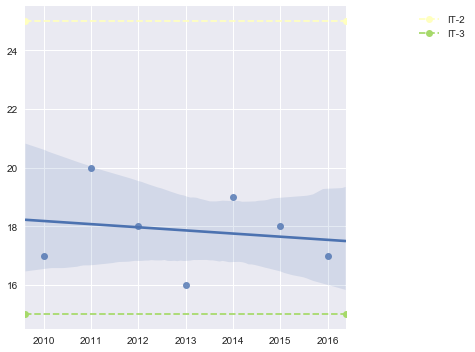

In [80]:
g = sns.lmplot(x='Year', y='PM25', data=who_air_all[who_air_all['City/Town'] == 'Sao Paulo']);
g.map(plt.axhline, y=25, color='#ffffbf',linestyle='--', label='IT-2');
g.map(plt.axhline, y=15, color='#a6d96a',linestyle='--',label='IT-3');
plt.legend(loc='upper center', bbox_to_anchor=(1.3,1), ncol=1);

No significant improvement is noted in measured $PM_{2.5}$ for Sao Paulo.

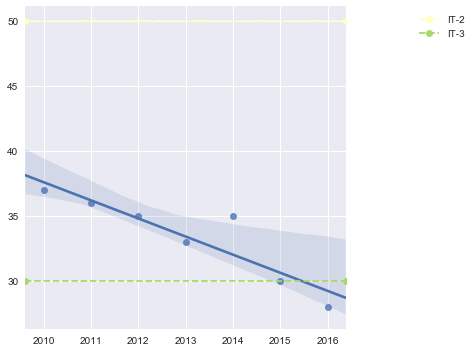

In [79]:
g = sns.lmplot(x='Year', y='PM10', data=who_air_all[who_air_all['City/Town'] == 'Sao Paulo']);
g.map(plt.axhline, y=50, color='#ffffbf',linestyle='--', label='IT-2');
g.map(plt.axhline, y=30, color='#a6d96a',linestyle='--',label='IT-3');
plt.legend(loc='upper center', bbox_to_anchor=(1.3,1), ncol=1);

However, $PM_{10}$ for Sao Paulo has improved from IT-2 to IT-3 target level.

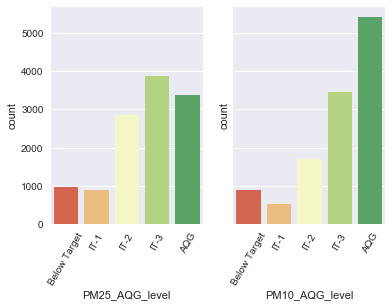

In [78]:
fig, ax =plt.subplots(1,2, sharey=True)
sns.countplot(x='PM25_AQG_level', data=who_air_all, ax=ax[0], palette='RdYlGn', order=['Below Target', 'IT-1','IT-2','IT-3','AQG']);
sns.countplot(x='PM10_AQG_level', data=who_air_all, ax=ax[1], palette='RdYlGn', order=['Below Target', 'IT-1','IT-2','IT-3','AQG']);
for x in fig.axes:
    for label in x.get_xticklabels():
        label.set_rotation(60)

Looking across the full dataset, it can be seen that while a substantial proportion of settlements are not achieving the WHO Air Quality Guideline, most are reaching an interim target level. 

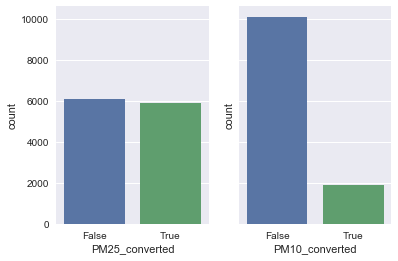

In [81]:
fig, ax =plt.subplots(1,2, sharey=True)
sns.countplot(x='PM25_converted', data=who_air_all, ax=ax[0]);
sns.countplot(x='PM10_converted', data=who_air_all, ax=ax[1]);

We can see that almost half of $PM_{2.5}$ readings in the full dataset are converted from $PM_{10}$ values, whereas a much smaller proportion of $PM_{10}$ readings are converted from $PM_{2.5}$ values. This might suggest that analysis should focus on $PM_{10}$ values since converted values are indicative due to conversion factors varying by location. However, we should note the following from the [WHO ambient air quality (outdoor) database Summary results, update 2018] (http://www.who.int/airpollution/data/AAP_database_summary_results_2018_final2.pdf) which suggests we should focus on $PM_{2.5}$ measurements:
> $PM_{2.5}$ measurements can directly be used to estimate health impact, and are therefore of particular interest. When $PM_{2.5}$ measurements are not available, $PM_{10}$ measurements need to be converted to $PM_{2.5}$. In high income countries, $PM_{2.5}$ measurements are already being widely performed. In many low and middle income countries, while $PM_{2.5}$ measures are still not available, there has been large improvements over the last years  


### Latest $PM_{2.5}$ measurement data

In [82]:
who_air_pm25_latest.describe()

,Year,PM25
count,2625.000000,2625.000000
mean,2015.303238,18.926476
std,1.108556,18.450089
min,2008.000000,2.000000
25%,2015.000000,8.000000
50%,2016.000000,12.000000
75%,2016.000000,22.000000
max,2017.000000,173.000000


We have latest available $PM_{2.5}$ measurements for over 2500 distinct settlements. Note these are all measured values for $PM_{2.5}$ i.e. not converted $PM_{10}$ values.

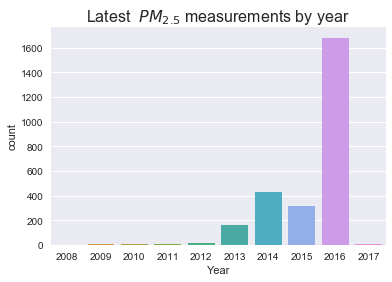

In [83]:
ax = sns.countplot(x='Year', data=who_air_pm25_latest);
ax.set_title('Latest  $PM_{2.5}$ measurements by year',fontsize=16);

We can see that the latest $PM_{2.5}$ measurements are primarily from the years 2013 to 2016.

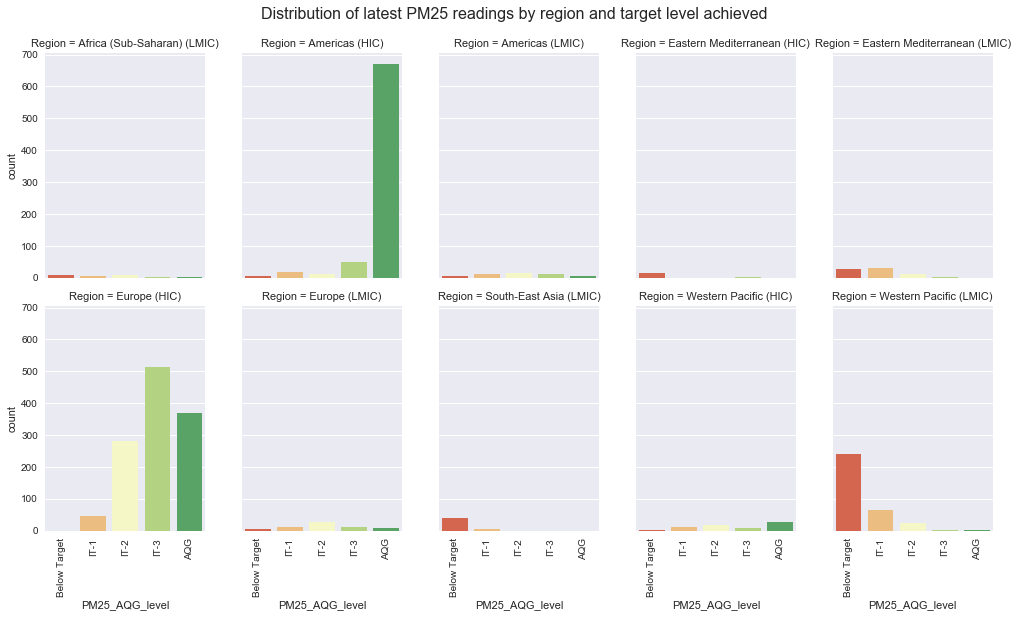

In [84]:
g = sns.factorplot(x='PM25_AQG_level', col='Region', data=who_air_pm25_latest, kind="count", 
                   aspect=0.7, col_wrap=5, palette='RdYlGn', order=['Below Target', 'IT-1','IT-2','IT-3','AQG']);
g.set_xticklabels(rotation=90)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of latest PM25 readings by region and target level achieved', fontsize=16);

The quantity of data available and its distribution varies considerably by region. We may want to investigate how representative the data is in terms of what proportion of settlements in each region actually have measurements available.

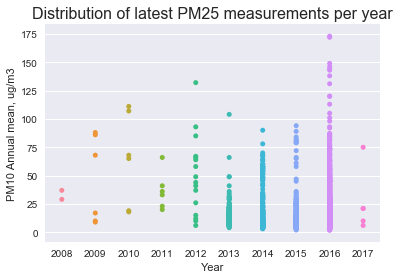

In [85]:
ax = sns.stripplot(x='Year',y='PM25',data=who_air_pm25_latest);
plt.ylabel('PM10 Annual mean, ug/m3');
ax.set_title('Distribution of latest PM25 measurements per year', fontsize=16);

# London Air Quality

The full WHO dataset has 4 observations for London with the most recent measured values dating from 2016.

In [86]:
who_air_all[(who_air_all['City/Town'] == 'London') & (who_air_all['Country']=='United Kingdom')]

,Region,iso3,Country,City/Town,Year,PM10,PM10_converted,PM25,PM25_converted,PM10_AQG_level,PM25_AQG_level
6865,Europe (HIC),GBR,United Kingdom,London,2013,24,False,15,False,IT-3,IT-3
6866,Europe (HIC),GBR,United Kingdom,London,2014,23,False,14,False,IT-3,IT-3
6867,Europe (HIC),GBR,United Kingdom,London,2015,22,False,12,False,IT-3,IT-3
6868,Europe (HIC),GBR,United Kingdom,London,2016,23,False,12,False,IT-3,IT-3


London is a large city and it is difficult to say how representative they are for air quality in the city as a whole.

In [97]:
who_air_all_raw[(who_air_all_raw['City/Town'] == 'London') & (who_air_all_raw['Country']=='United Kingdom')]\
    [['Region','iso3','Country','City/Town','Year','Number and type of monitoring stations','Reference for air quality']]

,Region,iso3,Country,City/Town,Year,Number and type of monitoring stations,Reference for air quality
6865,Europe (HIC),GBR,United Kingdom,London,2013,"5 Urban-Background, 5 Urban-Traffic",The European Environmental Agency (EEA) [downl...
6866,Europe (HIC),GBR,United Kingdom,London,2014,"1 Suburban-Background, 5 Urban-Background, 6 U...",The European Environmental Agency (EEA) [downl...
6867,Europe (HIC),GBR,United Kingdom,London,2015,"1 Suburban-Background, 7 Urban-Background, 6 U...",The European Environmental Agency (EEA) [downl...
6868,Europe (HIC),GBR,United Kingdom,London,2016,"1 Suburban-Background, 5 Urban-Background, 7 U...",The European Environmental Agency (EEA) [downl...


Referring back to the raw data we can see the source of London measurements to [European Environmental Agency (EEA) air quality reporting](https://www.eea.europa.eu/data-and-maps/data/aqereporting-8). The number of monitoring stations providing data is seen to be between 10 and 15 during this period. 

TO-DO: Verify EEA data matches WHO.


However, in order to look more closely at the situation in London we will utilise the [London Average Air Quality Levels](https://data.london.gov.uk/dataset/london-average-air-quality-levels) dataset supplied by King's College which utilises a broader network of over 100 monitoring locations. 

## Import Data

London Average Air Quality data is published monthly in CSV format by King's College. This was downloaded locally in order to perform some minor formatting of the column headers. 

The source file contains information on a number of pollutants measured every 15 minutes across the [London Air Quality Network](https://www.londonair.org.uk/LondonAir/Default.aspx). Monthly averages are calculated from these measurements. Note that previously in the WHO dataset we were using annual average $PM_{2.5}$ and $PM_{10}$. We do not have location information as the observations are calculated across the network of montoring stations.

In [98]:
london_air_monthly_raw = pd.read_csv('air-quality-london-monthly-averages.csv', parse_dates=['Month'],index_col='Month',na_values=['.'])
london_air_monthly_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2008-01-01 to 2018-04-01
Data columns (total 14 columns):
London Mean Roadside:Nitric Oxide (ug/m3)            100 non-null float64
London Mean Roadside:Nitrogen Dioxide (ug/m3)        124 non-null float64
London Mean Roadside:Oxides of Nitrogen (ug/m3)      100 non-null float64
London Mean Roadside:Ozone (ug/m3)                   124 non-null float64
London Mean Roadside:PM10 Particulate (ug/m3)        124 non-null float64
London Mean Roadside:PM2.5 Particulate (ug/m3)       124 non-null float64
London Mean Roadside:Sulphur Dioxide (ug/m3)         124 non-null float64
London Mean Background:Nitric Oxide (ug/m3)          100 non-null float64
London Mean Background:Nitrogen Dioxide (ug/m3)      124 non-null float64
London Mean Background:Oxides of Nitrogen (ug/m3)    100 non-null float64
London Mean Background:Ozone (ug/m3)                 124 non-null float64
London Mean Background:PM10 Particulate (ug/m3)      124 non-n

## Wrangle Data

We can drop the columns that we do not require and retain the $PM_{2.5}$ / $PM_{10}$ measurements for both roadside and background. Columns names are also changed for simplicity.

In [99]:
london_air_monthly = london_air_monthly_raw[['London Mean Roadside:PM10 Particulate (ug/m3)','London Mean Roadside:PM2.5 Particulate (ug/m3)','London Mean Background:PM10 Particulate (ug/m3)','London Mean Background:PM2.5 Particulate (ug/m3)']]
london_air_monthly = london_air_monthly.rename(columns={'London Mean Roadside:PM10 Particulate (ug/m3)':'PM10_roadside', 'London Mean Roadside:PM2.5 Particulate (ug/m3)': 'PM25_roadside','London Mean Background:PM10 Particulate (ug/m3)':'PM10_background', 'London Mean Background:PM2.5 Particulate (ug/m3)': 'PM25_background'})
london_air_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2008-01-01 to 2018-04-01
Data columns (total 4 columns):
PM10_roadside      124 non-null float64
PM25_roadside      124 non-null float64
PM10_background    124 non-null float64
PM25_background    120 non-null float64
dtypes: float64(4)
memory usage: 4.8 KB


In [100]:
def add_freq(idx, freq=None):
    """#Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

We will want to anayse this data as a time series and need to assign the frequency of the index to indicate we have monthly data assigned to the start of each month.

In [103]:
print(add_freq(london_air_monthly.index))

DatetimeIndex(['2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=124, freq='MS')


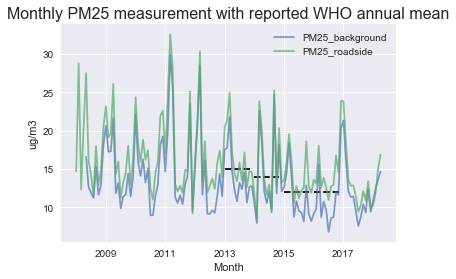

In [118]:
ax = london_air_monthly[['PM25_background','PM25_roadside']].plot(alpha=0.7);
ax.hlines(y=15, xmin='2013-01-01', xmax='2013-12-31',color='black',linestyle='--');
ax.hlines(y=14, xmin='2014-01-01', xmax='2014-12-31',color='black',linestyle='--');
ax.hlines(y=12, xmin='2015-01-01', xmax='2015-12-31',color='black',linestyle='--');
ax.hlines(y=12, xmin='2016-01-01', xmax='2016-12-31',color='black',linestyle='--');
plt.ylabel('ug/m3');
ax.set_title('Monthly PM25 measurement with reported WHO annual mean', fontsize=16);

In [ ]:
We can a potential trend within the data which we will investigate later.

In [121]:
# calculate rolling annual average
ma = london_air_monthly.rolling(window=12).mean()

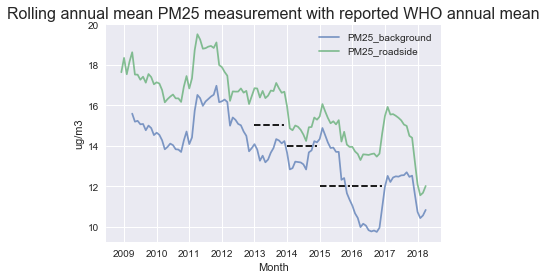

In [123]:
ax = ma[['PM25_background','PM25_roadside']].plot(alpha=0.7);
ax.hlines(y=15, xmin='2013-01-01', xmax='2013-12-31',color='black',linestyle='--');
ax.hlines(y=14, xmin='2014-01-01', xmax='2014-12-31',color='black',linestyle='--');
ax.hlines(y=12, xmin='2015-01-01', xmax='2015-12-31',color='black',linestyle='--');
ax.hlines(y=12, xmin='2016-01-01', xmax='2016-12-31',color='black',linestyle='--');
plt.ylabel('ug/m3');
ax.set_title('Rolling annual mean PM25 measurement with reported WHO annual mean', fontsize=16);

We can see that the annual mean $PM_{2.5}$ measurements reported to the WHO are close to the `PM25_background` rolling annual mean values for 2014 to 2016. For 2013, the reported WHO annual mean seems to be closer to the `PM25_roadside` level. 

C:\Users\jonbu\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


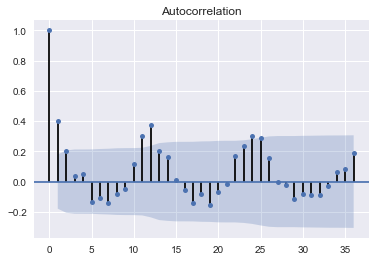

In [124]:
import statsmodels.api as sm
fig = sm.graphics.tsa.plot_acf(london_air_monthly.PM25_background.dropna(), lags=36);

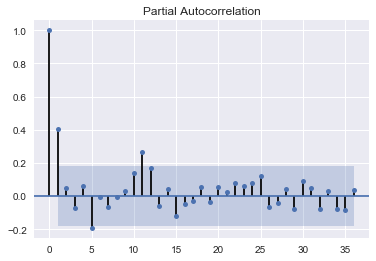

In [125]:
fig = sm.graphics.tsa.plot_pacf(london_air_monthly.PM25_background.dropna(), lags=36);

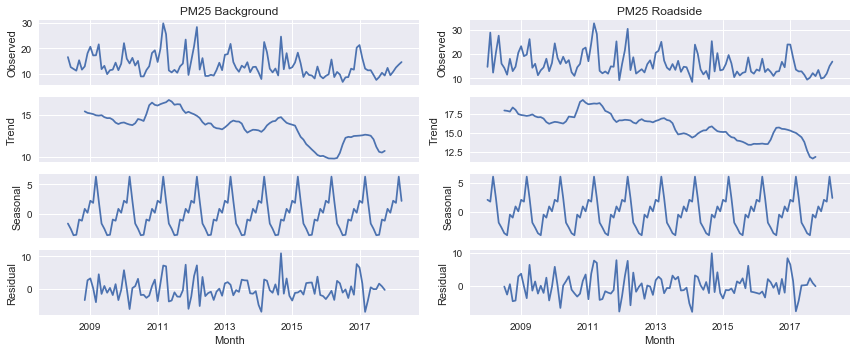

In [134]:
decomposition_background = sm.tsa.seasonal_decompose(london_air_monthly.PM25_background.dropna())
decomposition_roadside = sm.tsa.seasonal_decompose(london_air_monthly.PM25_roadside.dropna())

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(decomposition_background, axes[:,0])
axes[0, 0].set_title('PM25 Background')
plotseasonal(decomposition_roadside, axes[:,1])
axes[0, 1].set_title('PM25 Roadside')

plt.tight_layout()      


Decomposing the time series for `PM25_background` and `PM25_roadside` we can see clear seasonal patterns and some downward trend. However, both also show a considerable amount of residual variation.

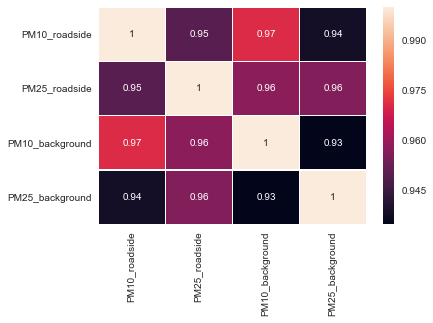

In [151]:
corr_pm = london_air_monthly.corr(method='pearson')
sns.heatmap(corr_pm,
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 10});
plt.xticks(rotation=90);
plt.yticks(rotation=0);

Given the similar patterns seen in the `PM25_background` and `PM25_roadside` time series it is not surprising to see the high correlation between these and also with the PM10 values.